# SET C - NOTEBOOK

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()


# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [3]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [4]:
Xtr.shape, Ytr.shape #dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [20]:
g = torch.Generator().manual_seed(2147483647) #For consistency ofcourse, to keep the same values as andrej
C = torch.randn((27,10), generator=g)
W1 = torch.rand((30, 300), generator=g)
b1 = torch.rand(300, generator=g)
W2 = torch.rand((300, 27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [21]:
sum(p.nelement() for p in parameters) # number of parameters in total

17697

In [22]:
for p in parameters:
    p.requires_grad = True

In [8]:

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [30]:
lri = []
lossi = []
stepi = []

for i in range(40000):

    #Minibatch
    xi = torch.randint(0, Xtr.shape[0], (32,))

    #forward pass
    emb = C[Xtr[xi]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[xi])
    #print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #keeping track
    #lri.append(lr)
    stepi.append(i)
    lossi.append(loss.item())

#print(loss.item())

The above cell will take a couple of seconds to run. Training a neural net can take a while, but luckily this is a very small neural network.

**Evaluation:**

In [31]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
devloss = F.cross_entropy(logits, Ydev)
devloss

tensor(2.1091, grad_fn=<NllLossBackward0>)

In [32]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
trloss = F.cross_entropy(logits, Ytr)
trloss

tensor(2.0482, grad_fn=<NllLossBackward0>)

Training and Dev loss are almost the same. So we know we are not overfitting. But what it typically means is that the Neural Net is very small, so essentially it is underfitting the data. \
\
Therefore to improve the performance we'll need to increase the size of the neural net.

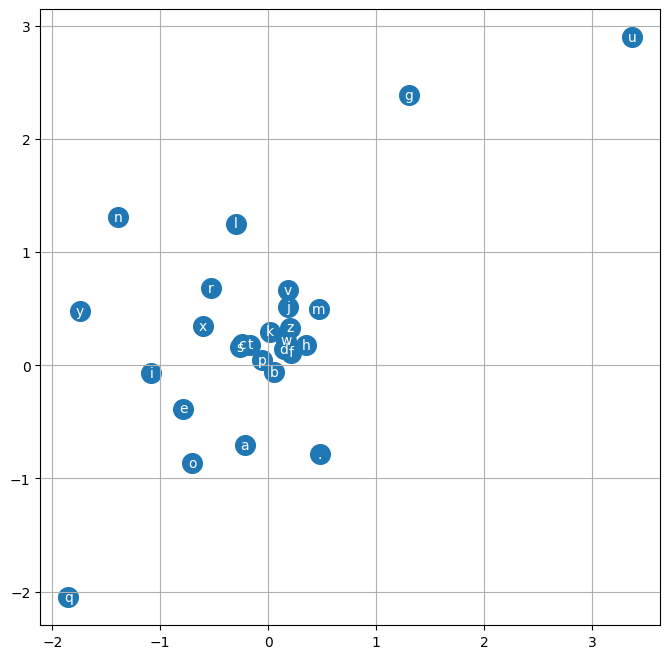

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

------------

-------------

Not much changes to what we have done so far, but just some code improvement for the lr value to change based on the iterations. 

Here basically we are open to experimenting with different values, whether it is the inputs, size of the layers or the loss rate values to see how we can decrease the final loss value.

In [ ]:
# ------------ now made respectable :) ---------------

In [33]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [34]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [35]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [36]:
lri = []
lossi = []
stepi = []

In [37]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

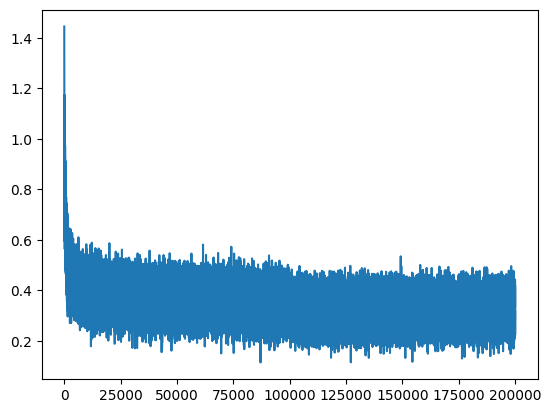

In [38]:
plt.plot(stepi, lossi)

In [39]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1294, grad_fn=<NllLossBackward0>)

In [40]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1677, grad_fn=<NllLossBackward0>)

----

**Sampling from the model**

In [41]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

Considering only one set of training set for simplicity rather than the entire training set^

In [42]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
kayah.
seel.
ndheyah.
reimanield.
leg.
adeerdoeliah.
milopaleigh.
eson.
arleitzion.
kalin.
shuhporxhimiel.
kin.
reelle.
joberlyn.
bren.
der.
yarue.
els.
kaysh.


To be fair, most of them could make sense lol. But atleast this time they definetely sound more name like, so we are defo making progress. So lessgoo xD

-----------